#### Resources:
- Paul Centore - A Zonohedral Approach to Optimal Colours
(https://legacy.sites.fas.harvard.edu/~cs278/papers/zone.pdf)
- Jessica Lee - Theory of Human Tetrachromatic Color Experience and Printing (https://imjal.github.io/theory-of-tetrachromacy/static/pdfs/Lee_TheoryofTet_v1.pdf)

#### Instructions:
Make sure to install Jessica's repository as a Python package using the line below. It requires Python 3.11.

In [6]:
!pip install -q git+https://github.com/VarunNSrivastava/ChromaLab

In [1]:
from chromalab.observer import Observer
from chromalab.spectra import Spectra, Illuminant
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm
import matplotlib.animation as animation
import pandas as pd
%matplotlib widget

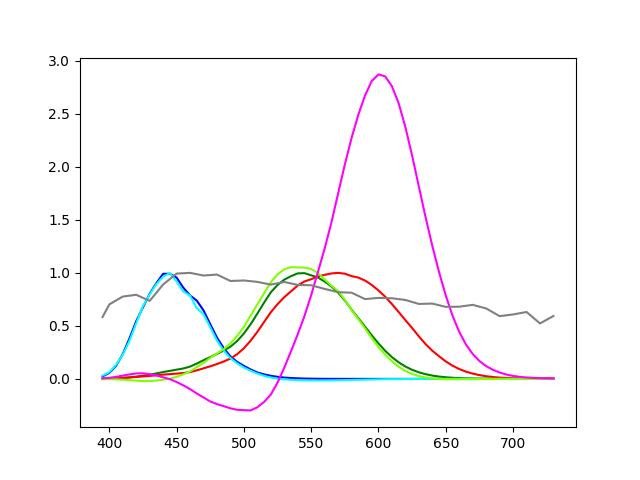

In [77]:
# Cone responses of a typical trichromat.
wavelengths = np.arange(395, 731, 5)
n = len(wavelengths)
standard_trichromat = Observer.trichromat(wavelengths)
illuminant = Illuminant.get("D65").interpolate_values(wavelengths)

df = pd.read_csv('data/sbrgb2.csv') # load ciergb data from stiles and burch 1955 from cvrl website
ciergb = df.values
ciergb = ciergb.T[1:]
ciergb[[0,2]] = ciergb[[2,0]]

# startidx = np.where(wavelengths[0]==ciergb[0])
# endidx = np.where(wavelengths[-1]==ciergb[0])
# print(endidx)
# ciergb = ciergb[1:, startidx : endidx + 1]
# print(ciergb)
plt.clf()
standard_trichromat.sensors[0].plot(color="blue")
standard_trichromat.sensors[1].plot(color="green")
standard_trichromat.sensors[2].plot(color="red")
plt.plot(wavelengths, ciergb[0], color="aqua")
plt.plot(wavelengths, ciergb[1], color="chartreuse")
plt.plot(wavelengths, ciergb[2], color="magenta")
illuminant.plot(color="gray")

# ax.axvline(x=573, color='gray', linestyle='--', label='Vertical Line')
# ax.axvspan(573, 700, color='lightgray', alpha=0.5)

# ax.set_xlabel('Wavelength')
# ax.set_ylabel('Sensitivity')
# ax.set_title('Cone Response Function')

# plt.savefig('cone_response_high.png', dpi=300, bbox_inches='tight')

plt.show()

In [78]:
# idk whats up with htis one but it gives me funky colors dont use
def computetransformationlms2rgb():
    # transform lms coordinates to a  cie xyz 1931 to Adobe RGB (1998)
    # for xyz to rgb http://www.brucelindbloom.com/index.html?Eqn_RGB_XYZ_Matrix.html
    # for xyz cmfs http://www.cvrl.org
    # and D65 reference white
    
    rgb_to_xyz = np.array([
    [0.4124564, 0.3575761, 0.1804375],
    [0.2126729, 0.7151522, 0.0721750],
    [0.0193339, 0.1191920, 0.9503041]])

    xyz_to_lms = np.array([
    [0.4002, 0.7076, -0.0808],
    [-0.2263, 1.1653, 0.0457],
    [0, 0, 0.9182]])
    return np.linalg.inv(xyz_to_lms @ rgb_to_xyz)

def lms2rgb(lmscoord, reflectance):
    # using ciergb color matching functions
    objectcolorlms = np.vstack((standard_trichromat.sensors[0].data, 
                           standard_trichromat.sensors[1].data, 
                           standard_trichromat.sensors[2].data)) * illuminant.data * np.vstack((reflectance,reflectance,reflectance))
    # we want to convert the object color to rgb; not the lms response, so above represents the object color in lms coords    
    A = ciergb @ objectcolorlms.T @ np.linalg.inv(lms_responses @ lms_responses.T) # moore penrose
    return A @ lmscoord

In [86]:
# Each point has an indicator reflectance function where R = 1 at a single wavelength and 0 elsewhere.
# These points can be thought of as vectors which form a (linearly dependent) basis.
# The Minkowski sum of these vectors span the object color solid.
# Each point in the solid can be represented as some (non-unique) linear combination of these vectors.
# This represents equations (9), (10), (11), (12), (13).
lms_responses = np.vstack((standard_trichromat.sensors[0].data, 
                           standard_trichromat.sensors[1].data, 
                           standard_trichromat.sensors[2].data)) * illuminant.data # optimal color vertices; cone cell dot illuminant

points = np.copy(lms_responses).T

# As shown in Centore's paper, these vertices form the shape of the solid.
# This represents the matrix in (7).
vertices = np.zeros((n + 1, n, 3))
vertexcolors = np.zeros((n + 1, n, 3))
for i in range(1, n + 1):
    for j in range(n):
        vertices[i, j] = vertices[i - 1, j] + points[(i + j - 1) % n]
        
# normalize all vertices so that whitepoint is (1,1,1); this is based on jessicas paper
vertices[:,:,0] = vertices[:,:,0] / np.max(vertices[:,:,0])
vertices[:,:,1] = vertices[:,:,1] / np.max(vertices[:,:,1])
vertices[:,:,2] = vertices[:,:,2] / np.max(vertices[:,:,2])

# rescale colors
# vertexcolors[:,:,0] = (vertexcolors[:,:,0] - np.min(vertexcolors[:,:,0])) / (np.max(vertexcolors[:,:,0]) - np.min(vertexcolors[:,:,0]))
# vertexcolors[:,:,1] = (vertexcolors[:,:,1] - np.min(vertexcolors[:,:,1])) / (np.max(vertexcolors[:,:,1]) - np.min(vertexcolors[:,:,1]))
# vertexcolors[:,:,2] = (vertexcolors[:,:,2] - np.min(vertexcolors[:,:,2])) / (np.max(vertexcolors[:,:,2]) - np.min(vertexcolors[:,:,2]))
vertexcolors[:,:,0] = np.clip(vertexcolors[:,:,0] / np.max(vertexcolors[:,:,0]), 0, 1)
vertexcolors[:,:,1] = np.clip(vertexcolors[:,:,1] / np.max(vertexcolors[:,:,1]), 0, 1)
vertexcolors[:,:,2] = np.clip(vertexcolors[:,:,2] / np.max(vertexcolors[:,:,2]), 0, 1)
# This represents the diagram in (8)
faces = np.zeros((n * (n - 1), 4, 3))
face_colors = np.zeros((n * (n - 1), 3))
for i in tqdm(range(1, n)):
    for j in range(n):
        faces[((i - 1) * n) + j, 0] = vertices[i, j]
        faces[((i - 1) * n) + j, 1] = vertices[i - 1, (j + 1) % n]
        faces[((i - 1) * n) + j, 2] = vertices[i, (j + 1) % n]
        faces[((i - 1) * n) + j, 3] = vertices[i + 1, j]
        
        # Calculate the reflectance on each face by using the reflectance of one of its vertices.
        # Since each vertex can be thought of as a linear combination of the basis vectors, 
        # the vertex's reflectance is the sum of reflectances of those vectors that made up the vertex.
        reflectance= np.zeros(n)
        for k in range(i):
            reflectance[(j + k) % n] = 1
        # reflectance = Spectra(wavelengths=wavelengths, data=reflectance_data)
        face_colors[(i - 1) * n + j] = lms2rgb(vertices[i, j], reflectance)    # Bottleneck. Takes about 3ms. 

# clip colors
# face_colors[:,0] = np.clip(face_colors[:,0]  / np.max(face_colors[:,0]), 0, 1)
# face_colors[:,1] = np.clip(face_colors[:,1] / np.max(face_colors[:,1]), 0, 1)
# face_colors[:,2] = np.clip(face_colors[:,2] / np.max(face_colors[:,2]), 0, 1)
# min max normalize
face_colors[:,0] = (face_colors[:,0] - np.min(face_colors[:,0]))  / (np.max(face_colors[:,0]) - np.min(face_colors[:,0])) 
face_colors[:,1] = (face_colors[:,1] - np.min(face_colors[:,1]))  / (np.max(face_colors[:,1]) - np.min(face_colors[:,1])) 
face_colors[:,2] = (face_colors[:,2] - np.min(face_colors[:,2]))  / (np.max(face_colors[:,2]) - np.min(face_colors[:,2])) 

/tmp/ipykernel_1729541/2984706423.py:30: RuntimeWarning: invalid value encountered in divide
  vertexcolors[:,:,0] = np.clip(vertexcolors[:,:,0] / np.max(vertexcolors[:,:,0]), 0, 1)
/tmp/ipykernel_1729541/2984706423.py:31: RuntimeWarning: invalid value encountered in divide
  vertexcolors[:,:,1] = np.clip(vertexcolors[:,:,1] / np.max(vertexcolors[:,:,1]), 0, 1)
/tmp/ipykernel_1729541/2984706423.py:32: RuntimeWarning: invalid value encountered in divide
  vertexcolors[:,:,2] = np.clip(vertexcolors[:,:,2] / np.max(vertexcolors[:,:,2]), 0, 1)
100%|█████████████████████████████████| 67/67 [00:00<00:00, 312.61it/s]


In [15]:
# Uses ideas from Jessica's paper, on chapter 3.2 The Max Basis.
# We use the cutpoints that Jessica shows to be optimal for the trichromatic case.
cutpoint_1 = 487
cutpoint_2 = 573
index_1 = None
index_2 = None
for i, wavelength in enumerate(wavelengths):
    if index_1 is None and wavelength > cutpoint_1:
        index_1 = i
    if index_2 is None and wavelength >= cutpoint_2:
        index_2 = i
        break

# We calculate the vectors p1, p2 and p3 as shown in the paper.
# We "project the partition into the cone response basis" by summing up all the lms_responses within each partition.
# Note that our earlier calculations for lms_responses includes the illuminant already.
p1 = np.sum(lms_responses[:, :index_1], axis=1).reshape((3, 1))
p2 = np.sum(lms_responses[:, index_1:index_2], axis=1).reshape((3, 1))
p3 = np.sum(lms_responses[:, index_2:], axis=1).reshape((3, 1))

# We then create a transformation matrix that maps p1 to (1, 0, 0), p2 to (0, 1, 0) and p3 to (1, 0, 0).
# p1, p2 and p3 correspond to the ideal R, G, B points on our object color solid, 
# and we are mapping them onto the R, G, B points on the RGB cube.
# We are essentially "stretching" our object color solid so that it approximates the RGB cube.
transformation_matrix = np.linalg.inv(np.hstack((p1, p2, p3)))
faces_transformed = np.matmul(faces, transformation_matrix.T)

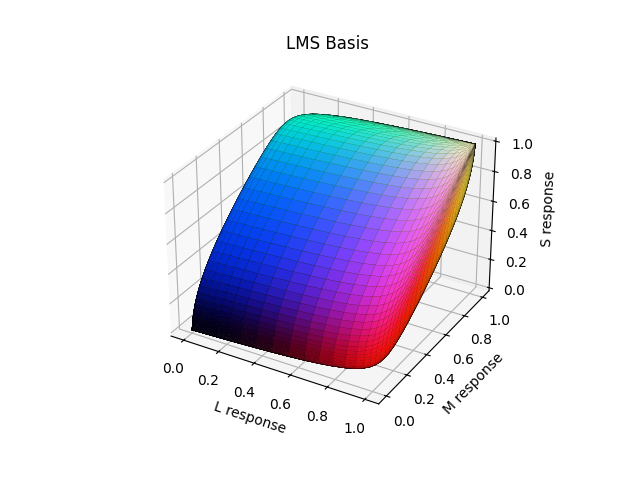

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
poly3d = Poly3DCollection(faces, linewidths=0.05, edgecolors='k')
poly3d.set_facecolor(face_colors)
ax.add_collection3d(poly3d)
ax.set_title('LMS Basis')
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])
ax.set_xlabel('L response')
ax.set_ylabel('M response')
ax.set_zlabel('S response')
plt.savefig('solid_lms_basis.png', dpi=300, bbox_inches='tight')
plt.show()